In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch.autograd as autograd

In [2]:
beta1 = 0
beta2 = 0.9
p_coeff = 10
n_critic = 5
lr = 1e-4
epoch_num = 3512
batch_size = 32
nz = 100  # length of noise
ngpu = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
class Dataset():
    def __init__(self, root):
        self.root = root
        self.dataset = self.build_dataset()
        self.length = self.dataset.shape[1]
        self.minmax_normalize()

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        step = self.dataset[:, idx]
        step = torch.unsqueeze(step, 0)
        target = 0  # Only one class
        return step, target

    def build_dataset(self):
        '''Get dataset of signals from CSV files'''
        dataset = []
        file_names = [f'Channel_{596}_Outage{41}.csv']  # List of file names
        for _file in file_names:
            file_path = os.path.join(self.root, _file)
            # Load the CSV file, skipping the header row
            sample = np.loadtxt(file_path, delimiter=',', skiprows=1).T
            dataset.append(sample)
        dataset = np.vstack(dataset).T
        dataset = torch.from_numpy(dataset).float()
        return dataset

    def minmax_normalize(self):
        '''Return min-max normalized dataset'''
        for index in range(self.length):
            self.dataset[:, index] = (self.dataset[:, index] - self.dataset[:, index].min()) / (
                self.dataset[:, index].max() - self.dataset[:, index].min())

# Usage
root_path = 'C:CSV-IES-BusFault-Voltage/'
dataset = Dataset(root_path)

if __name__ == '__main__':
    dataset = Dataset(root_path)
    #plt.plot(dataset.dataset[:, 0])
    #plt.show()

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        layers = [
            ('conv1', nn.Conv1d(1, 64, kernel_size=4, stride=2, padding=1, bias=False)),
            ('leaky_relu1', nn.LeakyReLU(0.2, inplace=True)),
            ('conv2', nn.Conv1d(64, 128, kernel_size=4, stride=2, padding=1, bias=False)),
            ('batch_norm2', nn.BatchNorm1d(128)),
            ('leaky_relu2', nn.LeakyReLU(0.2, inplace=True)),
            ('conv3', nn.Conv1d(128, 256, kernel_size=4, stride=2, padding=1, bias=False)),
            ('batch_norm3', nn.BatchNorm1d(256)),
            ('leaky_relu3', nn.LeakyReLU(0.2, inplace=True)),
            ('conv4', nn.Conv1d(256, 512, kernel_size=4, stride=2, padding=1, bias=False)),
            ('batch_norm4', nn.BatchNorm1d(512)),
            ('leaky_relu4', nn.LeakyReLU(0.2, inplace=True)),
            ('conv5', nn.Conv1d(512, 1, kernel_size=114, stride=1, padding=0, bias=False)),
            ('sigmoid', nn.Sigmoid())
        ]
        
        self.main = nn.Sequential()
        
        for name, layer in layers:
            self.main.add_module(name, layer)
        
    def forward(self, x, y=None):
        x = self.main(x)
        return x

In [ ]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        layers = []
        layer_specs = [
            (nn.ConvTranspose1d(nz, 512, 114, 1, 0, bias=False), nn.BatchNorm1d(512), nn.ReLU(True)),
            (nn.ConvTranspose1d(512, 256, 4, 2, 1, bias=False), nn.BatchNorm1d(256), nn.ReLU(True)),
            (nn.ConvTranspose1d(256, 128, 4, 2, 1, bias=False), nn.BatchNorm1d(128), nn.ReLU(True)),
            (nn.ConvTranspose1d(128, 64, 4, 2, 1, bias=False), nn.BatchNorm1d(64), nn.ReLU(True)),
            (nn.ConvTranspose1d(64, 1, 4, 2, 1, bias=False), nn.Tanh())
        ]
        
        for spec in layer_specs:
            layers.extend(spec)
        
        self.main = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.main(x)

In [6]:
def plot_losses(losses_D, losses_G, epoch_num):
    epochs = range(epoch_num)
    
    # Create a DataFrame
    losses_df = pd.DataFrame({'Epoch': epochs, 'Discriminator Loss': losses_D, 'Generator Loss': losses_G})

    # Save DataFrame to an Excel file
    excel_file_path = 'gan_losses_data.xlsx'
    losses_df.to_excel(excel_file_path, index=False)
    
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, losses_D, label="Discriminator Loss", alpha=0.5)
    plt.plot(epochs, losses_G, label="Generator Loss", alpha=0.5)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    # Increase font size for tick labels on both axes
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=14)
    plt.title('Discriminator and Generator Losses', fontsize=14)
    plt.savefig('gan_losses_plot.pdf')
    plt.show()

In [7]:
# Add this function to your script
def plot_discriminator_outputs(outputs, epoch):
    plt.figure(figsize=(10, 5))
    plt.plot(outputs, label='Discriminator Output')
    plt.xlabel('Epochs')
    plt.ylabel('Sigmoid Output Value')
    plt.title(f'Discriminator Output Values')
    plt.legend()
    plt.grid(True)
    plt.savefig('Sigmoid.pdf')
    plt.show()

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:
losses_D = []
losses_G = []
discriminator_outputs = []

In [10]:
def main():
    # load training data
    trainset = Dataset(root_path)
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True
    )

    # init netD and netG
    netD = Discriminator().to(device)
    netD.apply(weights_init)
    netG = Generator(nz).to(device)
    netG.apply(weights_init)

    # used for visualizing training process
    fixed_noise = torch.randn(16, nz, 1, device=device)

    # optimizers
    # optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, beta2))
    # optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, beta2))
    optimizerD = optim.RMSprop(netD.parameters(), lr=lr)
    optimizerG = optim.RMSprop(netG.parameters(), lr=lr)
    for epoch in range(epoch_num):
        for step, (data, _) in enumerate(trainloader):
            # training netD
            real_cpu = data.to(device)
            b_size = real_cpu.size(0)
            netD.zero_grad()
            noise = torch.randn(b_size, nz, 1, device=device)
            fake = netG(noise)

            # gradient penalty
            eps = torch.Tensor(b_size, 1, 1).uniform_(0, 1)
            x_p = eps * data + (1 - eps) * fake
            grad = autograd.grad(netD(x_p).mean(), x_p, create_graph=True, retain_graph=True)[0].view(b_size, -1)
            grad_norm = torch.norm(grad, 2, 1)
            grad_penalty = p_coeff * torch.pow(grad_norm - 1, 2)
            loss_D = torch.mean(netD(fake) - netD(real_cpu))
            loss_D.backward()
            optimizerD.step()
            

            
            for p in netD.parameters():
                p.data.clamp_(-0.01, 0.01)
            if step % n_critic == 0:
                # training netG
                noise = torch.randn(b_size, nz, 1, device=device)
                netG.zero_grad()
                fake = netG(noise)
                loss_G = -torch.mean(netD(fake))
                netD.zero_grad()
                netG.zero_grad()
                loss_G.backward()
                optimizerG.step()
                
            # Append discriminator output values to the list
            discriminator_outputs.append(torch.mean(netD(fake)).item())
                
                
            if step % 10 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                      % (epoch, epoch_num, step, len(trainloader), loss_D.item(), loss_G.item()))
        # Append loss values for the current epoch
        losses_D.append(loss_D.item())
        losses_G.append(loss_G.item())
        
        

        # save training process
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
            f, a = plt.subplots(4, 4, figsize=(8, 8))
            for i in range(4):
                for j in range(4):
                    a[i][j].plot(fake[i * 4 + j].view(-1))
                    a[i][j].set_xticks(())
                    a[i][j].set_yticks(())
            #plt.savefig('./img/wgan_gp_epoch_%d.png' % epoch)
            plt.savefig(r'C:gan_epoch_%d.png' % epoch)
            plt.close()
            
            
    # Plot discriminator output values after each epoch
    plot_discriminator_outputs(discriminator_outputs, epoch)
    
    # save models
    torch.save(netG, r'C:\nets\dcgan_netG.pkl')
    torch.save(netD, r'C:\nets\dcgan_netD.pkl')
    

[0/3512][0/5]	Loss_D: 0.1140	Loss_G: -0.4966
[1/3512][0/5]	Loss_D: -0.0015	Loss_G: -0.4960
[2/3512][0/5]	Loss_D: -0.0028	Loss_G: -0.4955
[3/3512][0/5]	Loss_D: -0.0039	Loss_G: -0.4947
[4/3512][0/5]	Loss_D: -0.0058	Loss_G: -0.4937
[5/3512][0/5]	Loss_D: -0.0065	Loss_G: -0.4931
[6/3512][0/5]	Loss_D: -0.0093	Loss_G: -0.4935
[7/3512][0/5]	Loss_D: -0.0067	Loss_G: -0.4957
[8/3512][0/5]	Loss_D: -0.0056	Loss_G: -0.4954
[9/3512][0/5]	Loss_D: -0.0051	Loss_G: -0.5002
[10/3512][0/5]	Loss_D: -0.0059	Loss_G: -0.4991
[11/3512][0/5]	Loss_D: -0.0057	Loss_G: -0.4999
[12/3512][0/5]	Loss_D: -0.0065	Loss_G: -0.4975
[13/3512][0/5]	Loss_D: -0.0031	Loss_G: -0.4965
[14/3512][0/5]	Loss_D: -0.0078	Loss_G: -0.4964
[15/3512][0/5]	Loss_D: -0.0045	Loss_G: -0.4947
[16/3512][0/5]	Loss_D: -0.0074	Loss_G: -0.4971
[17/3512][0/5]	Loss_D: -0.0041	Loss_G: -0.4963
[18/3512][0/5]	Loss_D: -0.0052	Loss_G: -0.4955
[19/3512][0/5]	Loss_D: -0.0066	Loss_G: -0.4960
[20/3512][0/5]	Loss_D: -0.0025	Loss_G: -0.4969
[21/3512][0/5]	Loss_D: -

[173/3512][0/5]	Loss_D: -0.1434	Loss_G: -0.4354
[174/3512][0/5]	Loss_D: -0.1534	Loss_G: -0.3722
[175/3512][0/5]	Loss_D: -0.1396	Loss_G: -0.4339
[176/3512][0/5]	Loss_D: -0.1516	Loss_G: -0.3776
[177/3512][0/5]	Loss_D: -0.1222	Loss_G: -0.4166
[178/3512][0/5]	Loss_D: -0.1413	Loss_G: -0.4365
[179/3512][0/5]	Loss_D: -0.1407	Loss_G: -0.3960
[180/3512][0/5]	Loss_D: -0.1430	Loss_G: -0.4279
[181/3512][0/5]	Loss_D: -0.1485	Loss_G: -0.4501
[182/3512][0/5]	Loss_D: -0.1627	Loss_G: -0.3965
[183/3512][0/5]	Loss_D: -0.1005	Loss_G: -0.3601
[184/3512][0/5]	Loss_D: -0.1195	Loss_G: -0.4694
[185/3512][0/5]	Loss_D: -0.1517	Loss_G: -0.4057
[186/3512][0/5]	Loss_D: -0.1152	Loss_G: -0.4393
[187/3512][0/5]	Loss_D: -0.1590	Loss_G: -0.4546
[188/3512][0/5]	Loss_D: -0.2033	Loss_G: -0.4576
[189/3512][0/5]	Loss_D: -0.1024	Loss_G: -0.3697
[190/3512][0/5]	Loss_D: -0.1536	Loss_G: -0.4471
[191/3512][0/5]	Loss_D: -0.1305	Loss_G: -0.3779
[192/3512][0/5]	Loss_D: -0.1447	Loss_G: -0.4159
[193/3512][0/5]	Loss_D: -0.1735	Loss_G: 

[344/3512][0/5]	Loss_D: -0.2153	Loss_G: -0.3951
[345/3512][0/5]	Loss_D: -0.2995	Loss_G: -0.2928
[346/3512][0/5]	Loss_D: -0.2183	Loss_G: -0.4177
[347/3512][0/5]	Loss_D: -0.2395	Loss_G: -0.4412
[348/3512][0/5]	Loss_D: -0.2950	Loss_G: -0.3627
[349/3512][0/5]	Loss_D: -0.2744	Loss_G: -0.4292
[350/3512][0/5]	Loss_D: -0.2498	Loss_G: -0.2990
[351/3512][0/5]	Loss_D: -0.2010	Loss_G: -0.4272
[352/3512][0/5]	Loss_D: -0.2825	Loss_G: -0.3631
[353/3512][0/5]	Loss_D: -0.2802	Loss_G: -0.3604
[354/3512][0/5]	Loss_D: -0.2714	Loss_G: -0.3345
[355/3512][0/5]	Loss_D: -0.2740	Loss_G: -0.4032
[356/3512][0/5]	Loss_D: -0.2588	Loss_G: -0.4048
[357/3512][0/5]	Loss_D: -0.2454	Loss_G: -0.4052
[358/3512][0/5]	Loss_D: -0.3451	Loss_G: -0.3024
[359/3512][0/5]	Loss_D: -0.2529	Loss_G: -0.4201
[360/3512][0/5]	Loss_D: -0.2369	Loss_G: -0.4184
[361/3512][0/5]	Loss_D: -0.3280	Loss_G: -0.3309
[362/3512][0/5]	Loss_D: -0.2497	Loss_G: -0.3779
[363/3512][0/5]	Loss_D: -0.2515	Loss_G: -0.3643
[364/3512][0/5]	Loss_D: -0.2698	Loss_G: 

[515/3512][0/5]	Loss_D: -0.2282	Loss_G: -0.4011
[516/3512][0/5]	Loss_D: -0.2390	Loss_G: -0.3628
[517/3512][0/5]	Loss_D: -0.2716	Loss_G: -0.4250
[518/3512][0/5]	Loss_D: -0.2772	Loss_G: -0.3105
[519/3512][0/5]	Loss_D: -0.2937	Loss_G: -0.3080
[520/3512][0/5]	Loss_D: -0.3165	Loss_G: -0.3300
[521/3512][0/5]	Loss_D: -0.3082	Loss_G: -0.3442
[522/3512][0/5]	Loss_D: -0.2262	Loss_G: -0.4018
[523/3512][0/5]	Loss_D: -0.3087	Loss_G: -0.3934
[524/3512][0/5]	Loss_D: -0.2602	Loss_G: -0.3905
[525/3512][0/5]	Loss_D: -0.2968	Loss_G: -0.3280
[526/3512][0/5]	Loss_D: -0.2110	Loss_G: -0.4009
[527/3512][0/5]	Loss_D: -0.1768	Loss_G: -0.4169
[528/3512][0/5]	Loss_D: -0.3258	Loss_G: -0.3073
[529/3512][0/5]	Loss_D: -0.2363	Loss_G: -0.3374
[530/3512][0/5]	Loss_D: -0.2042	Loss_G: -0.4320
[531/3512][0/5]	Loss_D: -0.3458	Loss_G: -0.3151
[532/3512][0/5]	Loss_D: -0.2999	Loss_G: -0.3721
[533/3512][0/5]	Loss_D: -0.2688	Loss_G: -0.3399
[534/3512][0/5]	Loss_D: -0.2469	Loss_G: -0.4038
[535/3512][0/5]	Loss_D: -0.2570	Loss_G: 

[686/3512][0/5]	Loss_D: -0.4553	Loss_G: -0.3030
[687/3512][0/5]	Loss_D: -0.3013	Loss_G: -0.3781
[688/3512][0/5]	Loss_D: -0.4782	Loss_G: -0.2997
[689/3512][0/5]	Loss_D: -0.3444	Loss_G: -0.2937
[690/3512][0/5]	Loss_D: -0.2857	Loss_G: -0.4235
[691/3512][0/5]	Loss_D: -0.5499	Loss_G: -0.2209
[692/3512][0/5]	Loss_D: -0.4480	Loss_G: -0.2586
[693/3512][0/5]	Loss_D: -0.3449	Loss_G: -0.3737
[694/3512][0/5]	Loss_D: -0.3734	Loss_G: -0.2971
[695/3512][0/5]	Loss_D: -0.1860	Loss_G: -0.4222
[696/3512][0/5]	Loss_D: -0.5025	Loss_G: -0.2527
[697/3512][0/5]	Loss_D: -0.2166	Loss_G: -0.4357
[698/3512][0/5]	Loss_D: -0.4808	Loss_G: -0.2199
[699/3512][0/5]	Loss_D: -0.3797	Loss_G: -0.3463
[700/3512][0/5]	Loss_D: -0.2599	Loss_G: -0.3451
[701/3512][0/5]	Loss_D: -0.4328	Loss_G: -0.2698
[702/3512][0/5]	Loss_D: -0.2934	Loss_G: -0.3456
[703/3512][0/5]	Loss_D: -0.3662	Loss_G: -0.3009
[704/3512][0/5]	Loss_D: -0.4063	Loss_G: -0.2682
[705/3512][0/5]	Loss_D: -0.4052	Loss_G: -0.2496
[706/3512][0/5]	Loss_D: -0.3889	Loss_G: 

[857/3512][0/5]	Loss_D: -0.5623	Loss_G: -0.2270
[858/3512][0/5]	Loss_D: -0.4653	Loss_G: -0.2349
[859/3512][0/5]	Loss_D: -0.3036	Loss_G: -0.3483
[860/3512][0/5]	Loss_D: -0.4582	Loss_G: -0.2449
[861/3512][0/5]	Loss_D: -0.2382	Loss_G: -0.3825
[862/3512][0/5]	Loss_D: -0.4264	Loss_G: -0.2502
[863/3512][0/5]	Loss_D: -0.3379	Loss_G: -0.3263
[864/3512][0/5]	Loss_D: -0.4599	Loss_G: -0.3070
[865/3512][0/5]	Loss_D: -0.3281	Loss_G: -0.3413
[866/3512][0/5]	Loss_D: -0.4956	Loss_G: -0.2569
[867/3512][0/5]	Loss_D: -0.3266	Loss_G: -0.3072
[868/3512][0/5]	Loss_D: -0.2563	Loss_G: -0.4136
[869/3512][0/5]	Loss_D: -0.4327	Loss_G: -0.2802
[870/3512][0/5]	Loss_D: -0.2304	Loss_G: -0.4319
[871/3512][0/5]	Loss_D: -0.4504	Loss_G: -0.3107
[872/3512][0/5]	Loss_D: -0.2327	Loss_G: -0.4588
[873/3512][0/5]	Loss_D: -0.4080	Loss_G: -0.3099
[874/3512][0/5]	Loss_D: -0.2165	Loss_G: -0.3995
[875/3512][0/5]	Loss_D: -0.4275	Loss_G: -0.2821
[876/3512][0/5]	Loss_D: -0.2777	Loss_G: -0.3487
[877/3512][0/5]	Loss_D: -0.4042	Loss_G: 

[1028/3512][0/5]	Loss_D: -0.4341	Loss_G: -0.3365
[1029/3512][0/5]	Loss_D: -0.3432	Loss_G: -0.2740
[1030/3512][0/5]	Loss_D: -0.2630	Loss_G: -0.3895
[1031/3512][0/5]	Loss_D: -0.4424	Loss_G: -0.2726
[1032/3512][0/5]	Loss_D: -0.2944	Loss_G: -0.3971
[1033/3512][0/5]	Loss_D: -0.3465	Loss_G: -0.3493
[1034/3512][0/5]	Loss_D: -0.2301	Loss_G: -0.3649
[1035/3512][0/5]	Loss_D: -0.3742	Loss_G: -0.3297
[1036/3512][0/5]	Loss_D: -0.2029	Loss_G: -0.4588
[1037/3512][0/5]	Loss_D: -0.4013	Loss_G: -0.2854
[1038/3512][0/5]	Loss_D: -0.2589	Loss_G: -0.3358
[1039/3512][0/5]	Loss_D: -0.4606	Loss_G: -0.2849
[1040/3512][0/5]	Loss_D: -0.3174	Loss_G: -0.3875
[1041/3512][0/5]	Loss_D: -0.4335	Loss_G: -0.2693
[1042/3512][0/5]	Loss_D: -0.2879	Loss_G: -0.3228
[1043/3512][0/5]	Loss_D: -0.3414	Loss_G: -0.3072
[1044/3512][0/5]	Loss_D: -0.2306	Loss_G: -0.4288
[1045/3512][0/5]	Loss_D: -0.3833	Loss_G: -0.2998
[1046/3512][0/5]	Loss_D: -0.2648	Loss_G: -0.4039
[1047/3512][0/5]	Loss_D: -0.4490	Loss_G: -0.2822
[1048/3512][0/5]	Los

[1196/3512][0/5]	Loss_D: -0.4453	Loss_G: -0.2864
[1197/3512][0/5]	Loss_D: -0.2692	Loss_G: -0.4228
[1198/3512][0/5]	Loss_D: -0.3504	Loss_G: -0.3405
[1199/3512][0/5]	Loss_D: -0.2621	Loss_G: -0.3405
[1200/3512][0/5]	Loss_D: -0.3308	Loss_G: -0.3208
[1201/3512][0/5]	Loss_D: -0.2595	Loss_G: -0.3836
[1202/3512][0/5]	Loss_D: -0.3509	Loss_G: -0.3475
[1203/3512][0/5]	Loss_D: -0.2153	Loss_G: -0.4576
[1204/3512][0/5]	Loss_D: -0.4230	Loss_G: -0.2526
[1205/3512][0/5]	Loss_D: -0.2753	Loss_G: -0.3904
[1206/3512][0/5]	Loss_D: -0.3755	Loss_G: -0.3334
[1207/3512][0/5]	Loss_D: -0.2599	Loss_G: -0.4308
[1208/3512][0/5]	Loss_D: -0.4503	Loss_G: -0.2421
[1209/3512][0/5]	Loss_D: -0.3275	Loss_G: -0.3375
[1210/3512][0/5]	Loss_D: -0.1960	Loss_G: -0.3939
[1211/3512][0/5]	Loss_D: -0.3181	Loss_G: -0.3265
[1212/3512][0/5]	Loss_D: -0.2486	Loss_G: -0.2966
[1213/3512][0/5]	Loss_D: -0.3187	Loss_G: -0.3448
[1214/3512][0/5]	Loss_D: -0.4158	Loss_G: -0.2601
[1215/3512][0/5]	Loss_D: -0.2966	Loss_G: -0.3641
[1216/3512][0/5]	Los

[1364/3512][0/5]	Loss_D: -0.3135	Loss_G: -0.3318
[1365/3512][0/5]	Loss_D: -0.5945	Loss_G: -0.1986
[1366/3512][0/5]	Loss_D: -0.4716	Loss_G: -0.2270
[1367/3512][0/5]	Loss_D: -0.3207	Loss_G: -0.3748
[1368/3512][0/5]	Loss_D: -0.4606	Loss_G: -0.2490
[1369/3512][0/5]	Loss_D: -0.3286	Loss_G: -0.3177
[1370/3512][0/5]	Loss_D: -0.4529	Loss_G: -0.2718
[1371/3512][0/5]	Loss_D: -0.3100	Loss_G: -0.3712
[1372/3512][0/5]	Loss_D: -0.4627	Loss_G: -0.2521
[1373/3512][0/5]	Loss_D: -0.3340	Loss_G: -0.3210
[1374/3512][0/5]	Loss_D: -0.3768	Loss_G: -0.3118
[1375/3512][0/5]	Loss_D: -0.4354	Loss_G: -0.2970
[1376/3512][0/5]	Loss_D: -0.3454	Loss_G: -0.3053
[1377/3512][0/5]	Loss_D: -0.4920	Loss_G: -0.2205
[1378/3512][0/5]	Loss_D: -0.3888	Loss_G: -0.2887
[1379/3512][0/5]	Loss_D: -0.3444	Loss_G: -0.3418
[1380/3512][0/5]	Loss_D: -0.3843	Loss_G: -0.2707
[1381/3512][0/5]	Loss_D: -0.3205	Loss_G: -0.3721
[1382/3512][0/5]	Loss_D: -0.6083	Loss_G: -0.1823
[1383/3512][0/5]	Loss_D: -0.5909	Loss_G: -0.1863
[1384/3512][0/5]	Los

[1532/3512][0/5]	Loss_D: -0.2787	Loss_G: -0.3948
[1533/3512][0/5]	Loss_D: -0.4196	Loss_G: -0.2252
[1534/3512][0/5]	Loss_D: -0.3515	Loss_G: -0.3072
[1535/3512][0/5]	Loss_D: -0.2898	Loss_G: -0.2915
[1536/3512][0/5]	Loss_D: -0.2745	Loss_G: -0.3729
[1537/3512][0/5]	Loss_D: -0.4207	Loss_G: -0.2623
[1538/3512][0/5]	Loss_D: -0.2922	Loss_G: -0.3422
[1539/3512][0/5]	Loss_D: -0.4429	Loss_G: -0.2354
[1540/3512][0/5]	Loss_D: -0.2777	Loss_G: -0.3068
[1541/3512][0/5]	Loss_D: -0.3645	Loss_G: -0.2981
[1542/3512][0/5]	Loss_D: -0.3298	Loss_G: -0.3857
[1543/3512][0/5]	Loss_D: -0.4094	Loss_G: -0.2600
[1544/3512][0/5]	Loss_D: -0.2315	Loss_G: -0.3719
[1545/3512][0/5]	Loss_D: -0.4406	Loss_G: -0.2574
[1546/3512][0/5]	Loss_D: -0.2511	Loss_G: -0.3888
[1547/3512][0/5]	Loss_D: -0.4132	Loss_G: -0.2608
[1548/3512][0/5]	Loss_D: -0.2807	Loss_G: -0.3322
[1549/3512][0/5]	Loss_D: -0.3781	Loss_G: -0.2916
[1550/3512][0/5]	Loss_D: -0.3217	Loss_G: -0.3738
[1551/3512][0/5]	Loss_D: -0.4142	Loss_G: -0.2459
[1552/3512][0/5]	Los

[1700/3512][0/5]	Loss_D: -0.2374	Loss_G: -0.3723
[1701/3512][0/5]	Loss_D: -0.3092	Loss_G: -0.3333
[1702/3512][0/5]	Loss_D: -0.3028	Loss_G: -0.3248
[1703/3512][0/5]	Loss_D: -0.3169	Loss_G: -0.3417
[1704/3512][0/5]	Loss_D: -0.4039	Loss_G: -0.2953
[1705/3512][0/5]	Loss_D: -0.2451	Loss_G: -0.3897
[1706/3512][0/5]	Loss_D: -0.3914	Loss_G: -0.2836
[1707/3512][0/5]	Loss_D: -0.1999	Loss_G: -0.3874
[1708/3512][0/5]	Loss_D: -0.3790	Loss_G: -0.3060
[1709/3512][0/5]	Loss_D: -0.3164	Loss_G: -0.2889
[1710/3512][0/5]	Loss_D: -0.3442	Loss_G: -0.3099
[1711/3512][0/5]	Loss_D: -0.3674	Loss_G: -0.2822
[1712/3512][0/5]	Loss_D: -0.2276	Loss_G: -0.3468
[1713/3512][0/5]	Loss_D: -0.4248	Loss_G: -0.2422
[1714/3512][0/5]	Loss_D: -0.2306	Loss_G: -0.3465
[1715/3512][0/5]	Loss_D: -0.4210	Loss_G: -0.3123
[1716/3512][0/5]	Loss_D: -0.2697	Loss_G: -0.3554
[1717/3512][0/5]	Loss_D: -0.3652	Loss_G: -0.3205
[1718/3512][0/5]	Loss_D: -0.3506	Loss_G: -0.2432
[1719/3512][0/5]	Loss_D: -0.2689	Loss_G: -0.4064
[1720/3512][0/5]	Los

[1868/3512][0/5]	Loss_D: -0.3689	Loss_G: -0.3619
[1869/3512][0/5]	Loss_D: -0.1484	Loss_G: -0.4903
[1870/3512][0/5]	Loss_D: -0.3452	Loss_G: -0.3345
[1871/3512][0/5]	Loss_D: -0.1618	Loss_G: -0.4733
[1872/3512][0/5]	Loss_D: -0.2245	Loss_G: -0.4460
[1873/3512][0/5]	Loss_D: -0.3835	Loss_G: -0.2973
[1874/3512][0/5]	Loss_D: -0.2239	Loss_G: -0.4179
[1875/3512][0/5]	Loss_D: -0.1683	Loss_G: -0.4079
[1876/3512][0/5]	Loss_D: -0.3657	Loss_G: -0.3476
[1877/3512][0/5]	Loss_D: -0.1494	Loss_G: -0.4559
[1878/3512][0/5]	Loss_D: -0.3603	Loss_G: -0.3004
[1879/3512][0/5]	Loss_D: -0.1111	Loss_G: -0.5407
[1880/3512][0/5]	Loss_D: -0.2906	Loss_G: -0.4025
[1881/3512][0/5]	Loss_D: -0.3875	Loss_G: -0.2770
[1882/3512][0/5]	Loss_D: -0.1930	Loss_G: -0.4473
[1883/3512][0/5]	Loss_D: -0.3361	Loss_G: -0.3020
[1884/3512][0/5]	Loss_D: -0.1980	Loss_G: -0.4029
[1885/3512][0/5]	Loss_D: -0.3014	Loss_G: -0.3420
[1886/3512][0/5]	Loss_D: -0.2025	Loss_G: -0.3942
[1887/3512][0/5]	Loss_D: -0.3415	Loss_G: -0.3670
[1888/3512][0/5]	Los

[2036/3512][0/5]	Loss_D: -0.2314	Loss_G: -0.3720
[2037/3512][0/5]	Loss_D: -0.1483	Loss_G: -0.4442
[2038/3512][0/5]	Loss_D: -0.2774	Loss_G: -0.3920
[2039/3512][0/5]	Loss_D: -0.2555	Loss_G: -0.3485
[2040/3512][0/5]	Loss_D: -0.2868	Loss_G: -0.3774
[2041/3512][0/5]	Loss_D: -0.2459	Loss_G: -0.3151
[2042/3512][0/5]	Loss_D: -0.2580	Loss_G: -0.4050
[2043/3512][0/5]	Loss_D: -0.3112	Loss_G: -0.3197
[2044/3512][0/5]	Loss_D: -0.2169	Loss_G: -0.4560
[2045/3512][0/5]	Loss_D: -0.2521	Loss_G: -0.3596
[2046/3512][0/5]	Loss_D: -0.1565	Loss_G: -0.4445
[2047/3512][0/5]	Loss_D: -0.3309	Loss_G: -0.3208
[2048/3512][0/5]	Loss_D: -0.2268	Loss_G: -0.4304
[2049/3512][0/5]	Loss_D: -0.2020	Loss_G: -0.3518
[2050/3512][0/5]	Loss_D: -0.2044	Loss_G: -0.4247
[2051/3512][0/5]	Loss_D: -0.2225	Loss_G: -0.4167
[2052/3512][0/5]	Loss_D: -0.2613	Loss_G: -0.4457
[2053/3512][0/5]	Loss_D: -0.0973	Loss_G: -0.4885
[2054/3512][0/5]	Loss_D: -0.2340	Loss_G: -0.3821
[2055/3512][0/5]	Loss_D: -0.1529	Loss_G: -0.4790
[2056/3512][0/5]	Los

[2204/3512][0/5]	Loss_D: -0.1618	Loss_G: -0.4748
[2205/3512][0/5]	Loss_D: -0.3042	Loss_G: -0.3593
[2206/3512][0/5]	Loss_D: -0.0800	Loss_G: -0.5021
[2207/3512][0/5]	Loss_D: -0.1020	Loss_G: -0.4284
[2208/3512][0/5]	Loss_D: -0.2307	Loss_G: -0.3671
[2209/3512][0/5]	Loss_D: -0.1726	Loss_G: -0.4401
[2210/3512][0/5]	Loss_D: -0.2763	Loss_G: -0.3660
[2211/3512][0/5]	Loss_D: -0.1235	Loss_G: -0.4403
[2212/3512][0/5]	Loss_D: -0.2226	Loss_G: -0.3900
[2213/3512][0/5]	Loss_D: -0.1703	Loss_G: -0.3894
[2214/3512][0/5]	Loss_D: -0.2305	Loss_G: -0.3693
[2215/3512][0/5]	Loss_D: -0.1456	Loss_G: -0.4403
[2216/3512][0/5]	Loss_D: -0.2692	Loss_G: -0.3285
[2217/3512][0/5]	Loss_D: -0.1580	Loss_G: -0.4481
[2218/3512][0/5]	Loss_D: -0.1766	Loss_G: -0.4414
[2219/3512][0/5]	Loss_D: -0.2294	Loss_G: -0.4006
[2220/3512][0/5]	Loss_D: -0.1328	Loss_G: -0.4531
[2221/3512][0/5]	Loss_D: -0.3078	Loss_G: -0.3748
[2222/3512][0/5]	Loss_D: -0.1678	Loss_G: -0.3936
[2223/3512][0/5]	Loss_D: -0.2710	Loss_G: -0.4125
[2224/3512][0/5]	Los

[2372/3512][0/5]	Loss_D: -0.2869	Loss_G: -0.3719
[2373/3512][0/5]	Loss_D: -0.3593	Loss_G: -0.2835
[2374/3512][0/5]	Loss_D: -0.2295	Loss_G: -0.4151
[2375/3512][0/5]	Loss_D: -0.2904	Loss_G: -0.3036
[2376/3512][0/5]	Loss_D: -0.1925	Loss_G: -0.4355
[2377/3512][0/5]	Loss_D: -0.2954	Loss_G: -0.3297
[2378/3512][0/5]	Loss_D: -0.2432	Loss_G: -0.3797
[2379/3512][0/5]	Loss_D: -0.3811	Loss_G: -0.3063
[2380/3512][0/5]	Loss_D: -0.2145	Loss_G: -0.4184
[2381/3512][0/5]	Loss_D: -0.3479	Loss_G: -0.2950
[2382/3512][0/5]	Loss_D: -0.1948	Loss_G: -0.3988
[2383/3512][0/5]	Loss_D: -0.2719	Loss_G: -0.3687
[2384/3512][0/5]	Loss_D: -0.2324	Loss_G: -0.3802
[2385/3512][0/5]	Loss_D: -0.2382	Loss_G: -0.3956
[2386/3512][0/5]	Loss_D: -0.2625	Loss_G: -0.3655
[2387/3512][0/5]	Loss_D: -0.2031	Loss_G: -0.4506
[2388/3512][0/5]	Loss_D: -0.3763	Loss_G: -0.2815
[2389/3512][0/5]	Loss_D: -0.1745	Loss_G: -0.4422
[2390/3512][0/5]	Loss_D: -0.2498	Loss_G: -0.4129
[2391/3512][0/5]	Loss_D: -0.2825	Loss_G: -0.3361
[2392/3512][0/5]	Los

[2540/3512][0/5]	Loss_D: -0.1580	Loss_G: -0.3954
[2541/3512][0/5]	Loss_D: -0.3064	Loss_G: -0.3504
[2542/3512][0/5]	Loss_D: -0.1585	Loss_G: -0.4913
[2543/3512][0/5]	Loss_D: -0.1685	Loss_G: -0.4046
[2544/3512][0/5]	Loss_D: -0.3053	Loss_G: -0.3352
[2545/3512][0/5]	Loss_D: -0.1033	Loss_G: -0.4823
[2546/3512][0/5]	Loss_D: -0.2182	Loss_G: -0.4069
[2547/3512][0/5]	Loss_D: -0.2610	Loss_G: -0.3384
[2548/3512][0/5]	Loss_D: -0.0648	Loss_G: -0.4591
[2549/3512][0/5]	Loss_D: -0.2187	Loss_G: -0.3403
[2550/3512][0/5]	Loss_D: -0.1912	Loss_G: -0.4162
[2551/3512][0/5]	Loss_D: -0.3244	Loss_G: -0.2851
[2552/3512][0/5]	Loss_D: -0.1205	Loss_G: -0.4591
[2553/3512][0/5]	Loss_D: -0.2328	Loss_G: -0.3696
[2554/3512][0/5]	Loss_D: -0.1296	Loss_G: -0.4451
[2555/3512][0/5]	Loss_D: -0.2930	Loss_G: -0.3835
[2556/3512][0/5]	Loss_D: -0.2190	Loss_G: -0.4322
[2557/3512][0/5]	Loss_D: -0.2685	Loss_G: -0.3330
[2558/3512][0/5]	Loss_D: -0.1068	Loss_G: -0.4845
[2559/3512][0/5]	Loss_D: -0.2489	Loss_G: -0.4148
[2560/3512][0/5]	Los

[2708/3512][0/5]	Loss_D: -0.1733	Loss_G: -0.4326
[2709/3512][0/5]	Loss_D: -0.2142	Loss_G: -0.4087
[2710/3512][0/5]	Loss_D: -0.1649	Loss_G: -0.4662
[2711/3512][0/5]	Loss_D: -0.2102	Loss_G: -0.3817
[2712/3512][0/5]	Loss_D: -0.1587	Loss_G: -0.4182
[2713/3512][0/5]	Loss_D: -0.2943	Loss_G: -0.3634
[2714/3512][0/5]	Loss_D: -0.0859	Loss_G: -0.4906
[2715/3512][0/5]	Loss_D: -0.2071	Loss_G: -0.3827
[2716/3512][0/5]	Loss_D: -0.1828	Loss_G: -0.3873
[2717/3512][0/5]	Loss_D: -0.2249	Loss_G: -0.3808
[2718/3512][0/5]	Loss_D: -0.2216	Loss_G: -0.3711
[2719/3512][0/5]	Loss_D: -0.1473	Loss_G: -0.4201
[2720/3512][0/5]	Loss_D: -0.1981	Loss_G: -0.4310
[2721/3512][0/5]	Loss_D: -0.1845	Loss_G: -0.3963
[2722/3512][0/5]	Loss_D: -0.2574	Loss_G: -0.3673
[2723/3512][0/5]	Loss_D: -0.1511	Loss_G: -0.4427
[2724/3512][0/5]	Loss_D: -0.2608	Loss_G: -0.3900
[2725/3512][0/5]	Loss_D: -0.1703	Loss_G: -0.4807
[2726/3512][0/5]	Loss_D: -0.2758	Loss_G: -0.3655
[2727/3512][0/5]	Loss_D: -0.1563	Loss_G: -0.4690
[2728/3512][0/5]	Los

[2876/3512][0/5]	Loss_D: -0.1611	Loss_G: -0.4157
[2877/3512][0/5]	Loss_D: -0.2029	Loss_G: -0.4055
[2878/3512][0/5]	Loss_D: -0.1853	Loss_G: -0.4234
[2879/3512][0/5]	Loss_D: -0.2288	Loss_G: -0.3766
[2880/3512][0/5]	Loss_D: -0.1220	Loss_G: -0.4316
[2881/3512][0/5]	Loss_D: -0.2541	Loss_G: -0.3755
[2882/3512][0/5]	Loss_D: -0.1154	Loss_G: -0.4546
[2883/3512][0/5]	Loss_D: -0.2360	Loss_G: -0.3870
[2884/3512][0/5]	Loss_D: -0.1067	Loss_G: -0.4873
[2885/3512][0/5]	Loss_D: -0.1703	Loss_G: -0.4025
[2886/3512][0/5]	Loss_D: -0.2111	Loss_G: -0.3688
[2887/3512][0/5]	Loss_D: -0.1483	Loss_G: -0.4259
[2888/3512][0/5]	Loss_D: -0.2258	Loss_G: -0.3777
[2889/3512][0/5]	Loss_D: -0.1362	Loss_G: -0.4001
[2890/3512][0/5]	Loss_D: -0.1944	Loss_G: -0.3894
[2891/3512][0/5]	Loss_D: -0.1446	Loss_G: -0.4393
[2892/3512][0/5]	Loss_D: -0.1646	Loss_G: -0.4382
[2893/3512][0/5]	Loss_D: -0.2210	Loss_G: -0.3862
[2894/3512][0/5]	Loss_D: -0.1300	Loss_G: -0.4387
[2895/3512][0/5]	Loss_D: -0.2046	Loss_G: -0.3396
[2896/3512][0/5]	Los

[3044/3512][0/5]	Loss_D: -0.1418	Loss_G: -0.4402
[3045/3512][0/5]	Loss_D: -0.1768	Loss_G: -0.4073
[3046/3512][0/5]	Loss_D: -0.0900	Loss_G: -0.4614
[3047/3512][0/5]	Loss_D: -0.2049	Loss_G: -0.3862
[3048/3512][0/5]	Loss_D: -0.1475	Loss_G: -0.4753
[3049/3512][0/5]	Loss_D: -0.1529	Loss_G: -0.4518
[3050/3512][0/5]	Loss_D: -0.1646	Loss_G: -0.4252
[3051/3512][0/5]	Loss_D: -0.1770	Loss_G: -0.4486
[3052/3512][0/5]	Loss_D: -0.1736	Loss_G: -0.3999
[3053/3512][0/5]	Loss_D: -0.1310	Loss_G: -0.4195
[3054/3512][0/5]	Loss_D: -0.2040	Loss_G: -0.3757
[3055/3512][0/5]	Loss_D: -0.1007	Loss_G: -0.4656
[3056/3512][0/5]	Loss_D: -0.2155	Loss_G: -0.3699
[3057/3512][0/5]	Loss_D: -0.1062	Loss_G: -0.4882
[3058/3512][0/5]	Loss_D: -0.1938	Loss_G: -0.3676
[3059/3512][0/5]	Loss_D: -0.0972	Loss_G: -0.4660
[3060/3512][0/5]	Loss_D: -0.1360	Loss_G: -0.4345
[3061/3512][0/5]	Loss_D: -0.1523	Loss_G: -0.4458
[3062/3512][0/5]	Loss_D: -0.1521	Loss_G: -0.4213
[3063/3512][0/5]	Loss_D: -0.1540	Loss_G: -0.4407
[3064/3512][0/5]	Los

[3212/3512][0/5]	Loss_D: -0.1693	Loss_G: -0.4128
[3213/3512][0/5]	Loss_D: -0.1499	Loss_G: -0.4625
[3214/3512][0/5]	Loss_D: -0.1533	Loss_G: -0.4364
[3215/3512][0/5]	Loss_D: -0.2030	Loss_G: -0.4272
[3216/3512][0/5]	Loss_D: -0.1400	Loss_G: -0.4515
[3217/3512][0/5]	Loss_D: -0.1689	Loss_G: -0.4279
[3218/3512][0/5]	Loss_D: -0.1169	Loss_G: -0.4939
[3219/3512][0/5]	Loss_D: -0.1659	Loss_G: -0.4414
[3220/3512][0/5]	Loss_D: -0.1425	Loss_G: -0.4503
[3221/3512][0/5]	Loss_D: -0.1776	Loss_G: -0.4023
[3222/3512][0/5]	Loss_D: -0.1179	Loss_G: -0.4406
[3223/3512][0/5]	Loss_D: -0.1673	Loss_G: -0.4423
[3224/3512][0/5]	Loss_D: -0.1493	Loss_G: -0.4369
[3225/3512][0/5]	Loss_D: -0.1687	Loss_G: -0.4263
[3226/3512][0/5]	Loss_D: -0.1525	Loss_G: -0.4311
[3227/3512][0/5]	Loss_D: -0.1582	Loss_G: -0.4355
[3228/3512][0/5]	Loss_D: -0.1091	Loss_G: -0.5031
[3229/3512][0/5]	Loss_D: -0.1824	Loss_G: -0.4242
[3230/3512][0/5]	Loss_D: -0.1340	Loss_G: -0.4425
[3231/3512][0/5]	Loss_D: -0.1467	Loss_G: -0.4151
[3232/3512][0/5]	Los

[3380/3512][0/5]	Loss_D: -0.1241	Loss_G: -0.4081
[3381/3512][0/5]	Loss_D: -0.1888	Loss_G: -0.3927
[3382/3512][0/5]	Loss_D: -0.1531	Loss_G: -0.4030
[3383/3512][0/5]	Loss_D: -0.1859	Loss_G: -0.3938
[3384/3512][0/5]	Loss_D: -0.1211	Loss_G: -0.3874
[3385/3512][0/5]	Loss_D: -0.1893	Loss_G: -0.4428
[3386/3512][0/5]	Loss_D: -0.2061	Loss_G: -0.4434
[3387/3512][0/5]	Loss_D: -0.1491	Loss_G: -0.3941
[3388/3512][0/5]	Loss_D: -0.1652	Loss_G: -0.4026
[3389/3512][0/5]	Loss_D: -0.1688	Loss_G: -0.3948
[3390/3512][0/5]	Loss_D: -0.1651	Loss_G: -0.3820
[3391/3512][0/5]	Loss_D: -0.1023	Loss_G: -0.4072
[3392/3512][0/5]	Loss_D: -0.2032	Loss_G: -0.4345
[3393/3512][0/5]	Loss_D: -0.1661	Loss_G: -0.4084
[3394/3512][0/5]	Loss_D: -0.1828	Loss_G: -0.4126
[3395/3512][0/5]	Loss_D: -0.1558	Loss_G: -0.3894
[3396/3512][0/5]	Loss_D: -0.1934	Loss_G: -0.4610
[3397/3512][0/5]	Loss_D: -0.1414	Loss_G: -0.3762
[3398/3512][0/5]	Loss_D: -0.1473	Loss_G: -0.4062
[3399/3512][0/5]	Loss_D: -0.1319	Loss_G: -0.3724
[3400/3512][0/5]	Los

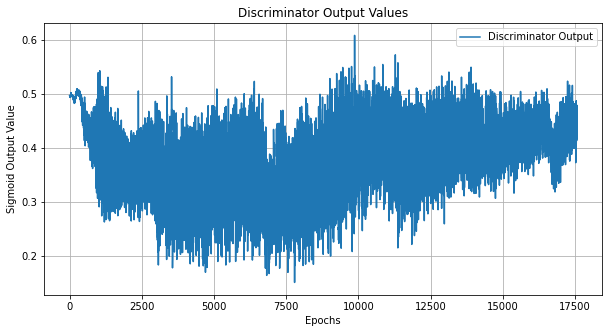

In [11]:
if __name__ == '__main__':
    main()

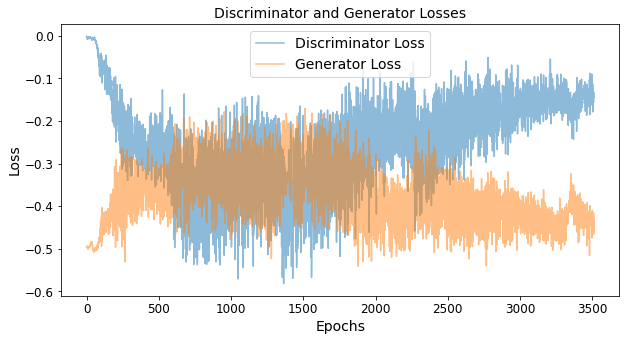

In [12]:
if __name__ == '__main__':
    plot_losses(losses_D, losses_G, epoch_num)

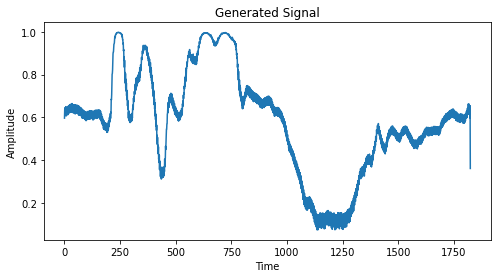

In [13]:
# Load the trained generator model
generator_path = r'C:\nets\dcgan_netG.pkl'
netG = torch.load(generator_path)
netG.eval()

# Generate a random noise vector
nz = 100  # Replace with your actual noise dimension
noise = torch.randn(1, nz, 1, device=device)  # You can adjust batch size if needed

# Use the generator to produce a signal from the noise
with torch.no_grad():
    generated_signal = netG(noise)

# Plot the generated signal
plt.figure(figsize=(8, 4))
plt.plot(generated_signal[0, 0, :].cpu().numpy())  # Adjust the indices as needed
plt.title("Generated Signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

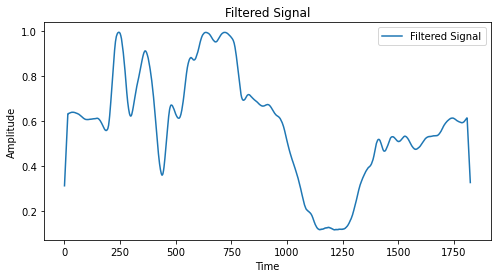

In [14]:
# Define the window size for the moving average filter
window_size = 30  # You can adjust this to suit your needs

# Apply the moving average filter
def moving_average_filter(signal, window_size):
    return np.convolve(signal, np.ones(window_size) / window_size, mode='same')

filtered_signal = moving_average_filter(generated_signal[0, 0, :].cpu().numpy(), window_size)
# Plot the original and filtered signals
plt.figure(figsize=(8, 4))
plt.plot(filtered_signal, label='Filtered Signal')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Filtered Signal')
plt.show()
# Save as an Excel file
df = pd.DataFrame(filtered_signal)
df.to_excel('FakeDATAset.xlsx', index=False)

In [15]:
# Save the filtered signal as an Excel file
df = pd.DataFrame({'Filtered Signal': filtered_signal})
df.to_excel('FilteredFakeSignal.xlsx', index=False)

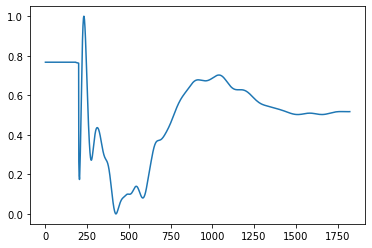

In [16]:
if __name__ == '__main__':
    dataset = Dataset(root_path)
    plt.plot(dataset.dataset[:, 8])
    plt.show()
    # Save the first column as an Excel file
    df = pd.DataFrame({'Column_0': dataset.dataset[:, 0]})
    df.to_excel('NormalizedDATAset.xlsx', index=False)

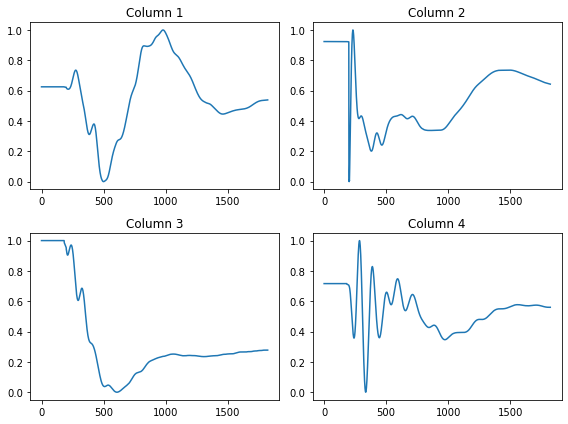

In [17]:
# Some Real Samples
if __name__ == '__main__':
    dataset = Dataset(root_path)  # Assuming you have a 'Dataset' class to load your data
    data = dataset.dataset  # Assuming 'dataset.dataset' is a 2D array with your data

    # Create a 2x2 grid of subplots
    fig, axes = plt.subplots(2, 2, figsize=(8, 6))  # You can adjust the figsize as needed

    # Plot the 1st column in the 1st subplot
    axes[0, 0].plot(data[:, 0])
    axes[0, 0].set_title('Column 1')

    # Plot the 2nd column in the 2nd subplot
    axes[0, 1].plot(data[:, 1])
    axes[0, 1].set_title('Column 2')

    # Plot the 3rd column in the 3rd subplot
    axes[1, 0].plot(data[:, 2])
    axes[1, 0].set_title('Column 3')

    # Plot the 4th column in the 4th subplot
    axes[1, 1].plot(data[:, 3])
    axes[1, 1].set_title('Column 4')

    plt.tight_layout()  # Adjust subplot spacing for better visualization
    plt.show()

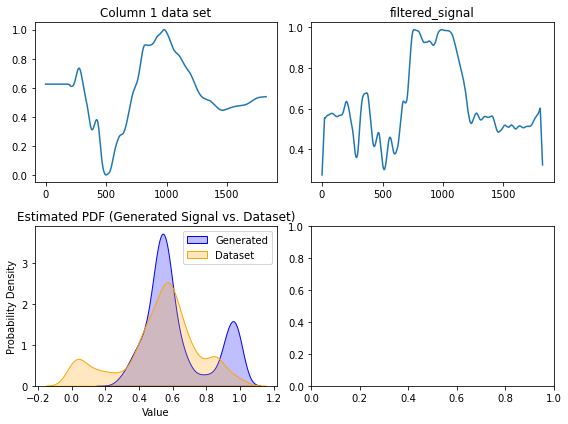

In [18]:
import seaborn as sns

if __name__ == '__main__':
    dataset = Dataset(root_path)  # Assuming you have a 'Dataset' class to load your data
    data = dataset.dataset  # Assuming 'dataset.dataset' is a 2D array with your data

    # Create a 2x2 grid of subplots
    fig, axes = plt.subplots(2, 2, figsize=(8, 6))  # You can adjust the figsize as needed

    # Plot the 1st column in the 1st subplot
    axes[0, 0].plot(data[:, 0])
    axes[0, 0].set_title('Column 1 data set')

    # Load the trained generator model
    generator_path = r'C:\nets\dcgan_netG.pkl'
    netG = torch.load(generator_path)
    netG.eval()

    # Generate a random noise vector
    nz = 100  # Replace with your actual noise dimension
    noise = torch.randn(1, nz, 1, device=device)  # You can adjust the batch size if needed

    # Use the generator to produce a signal from the noise
    with torch.no_grad():
        generated_signal = netG(noise)
        
    # Define the window size for the moving average filter
    window_size = 40  # You can adjust this to suit your needs

    # Apply the moving average filter
    def moving_average_filter(signal, window_size):
        return np.convolve(signal, np.ones(window_size) / window_size, mode='same')

    filtered_signal = moving_average_filter(generated_signal[0, 0, :].cpu().numpy(), window_size)

    # Plot the generated signal
    axes[0, 1].plot(filtered_signal)  # Adjust the indices as needed
    axes[0, 1].set_title("filtered_signal")

    # Estimate and plot the probability distribution of the generated signal
    sns.kdeplot(filtered_signal, color='blue', label='Generated', ax=axes[1, 0], fill=True)
    axes[1, 0].set_title("Estimated PDF (Generated Signal vs. Dataset)")
    axes[1, 0].set_xlabel("Value")
    axes[1, 0].set_ylabel("Probability Density")

    # Estimate and plot the probability distribution of the dataset
    sns.kdeplot(data[:, 149], color='orange', label='Dataset', ax=axes[1, 0], fill=True)

    axes[1, 0].legend()
    plt.tight_layout()
    # Save the plot as a PDF file
    plt.savefig("your_plot_filename.pdf")
    plt.show()


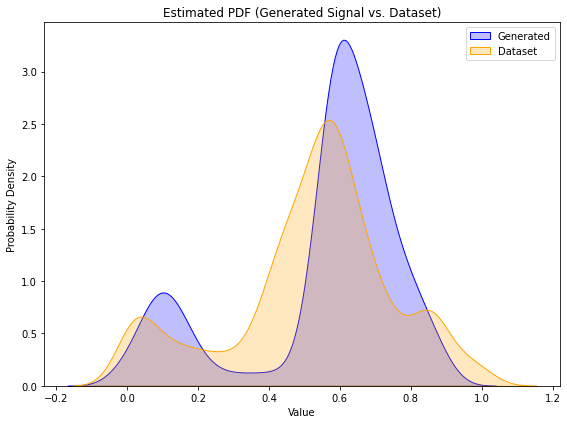

In [19]:
#Single Generated Signal
import seaborn as sns

if __name__ == '__main__':
    dataset = Dataset(root_path)  # Assuming you have a 'Dataset' class to load your data
    data = dataset.dataset  # Assuming 'dataset.dataset' is a 2D array with your data


    # Load the trained generator model
    generator_path = r'C:\nets\dcgan_netG.pkl'
    netG = torch.load(generator_path)
    netG.eval()

    # Generate a random noise vector
    nz = 100  # Replace with your actual noise dimension
    noise = torch.randn(1, nz, 1, device=device)  # You can adjust the batch size if needed

    # Use the generator to produce a signal from the noise
    with torch.no_grad():
        generated_signal = netG(noise)
        
    # Define the window size for the moving average filter
    window_size = 30  # You can adjust this to suit your needs

    # Apply the moving average filter
    def moving_average_filter(signal, window_size):
        return np.convolve(signal, np.ones(window_size) / window_size, mode='same')

    filtered_signal = moving_average_filter(generated_signal[0, 0, :].cpu().numpy(), window_size)
    # Create a single subplot
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the generated signal distribution
    sns.kdeplot(filtered_signal, color='blue', label='Generated', ax=ax, fill=True)

    # Plot the dataset distribution
    # Set a seed for reproducibility
    np.random.seed(42)
    sns.kdeplot(data[:, 149], color='orange', label='Dataset', ax=ax, fill=True)

    ax.set_title("Estimated PDF (Generated Signal vs. Dataset)")
    ax.set_xlabel("Value")
    ax.set_ylabel("Probability Density")
    ax.legend()

    plt.tight_layout()
    # Save the plot as a PDF file
    plt.savefig("your_plot_filename.pdf")
    plt.show()

In [20]:
# Dataset of Fake
# Load the trained generator model
generator_path = r'C:\nets\dcgan_netG.pkl'
netG = torch.load(generator_path)
netG.eval()

# Number of times to generate signals
num_samples = 160

# List to store generated signals
generated_signals_list = []

# Generate and store signals
for i in range(num_samples):
    # Generate a random noise vector
    noise = torch.randn(1, nz, 1, device=device)  # You can adjust batch size if needed

    # Use the generator to produce a signal from the noise
    with torch.no_grad():
        generated_signal = netG(noise).cpu().numpy().squeeze()

    generated_signals_list.append(generated_signal)
    
    

# Create a DataFrame, transpose it, and save it to an Excel file
df = pd.DataFrame(generated_signals_list).T
excel_filename = 'generated_signals.xlsx'
df.to_excel(excel_filename, header=[f'Sample_{i+1}' for i in range(num_samples)], index=False)

print(f'Data saved to {excel_filename}')

Data saved to generated_signals.xlsx


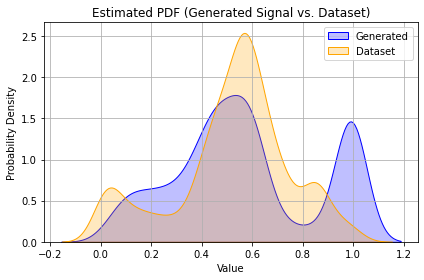

In [21]:
#Accumulated pdf

if __name__ == '__main__':
    # Assuming you have a 'Dataset' class to load your data
    dataset = Dataset(root_path)
    data = dataset.dataset  # Assuming 'dataset.dataset' is a 2D array with your data

    # Creating a subplot
    fig, ax = plt.subplots()

    # Assuming 'generated_signals.xlsx' is a pandas DataFrame
    generated_signals = pd.read_excel('generated_signals.xlsx')

    # Assuming the DataFrame has at least 4 columns
    sns.kdeplot(generated_signals.iloc[:, 8], color='blue', label='Generated', ax=ax, fill=True)

    # Set a seed for reproducibility
    np.random.seed(43)

 
    sns.kdeplot(data[:, 149], color='orange', label='Dataset', ax=ax, fill=True)

    ax.set_title("Estimated PDF (Generated Signal vs. Dataset)")
    ax.set_xlabel("Value")
    ax.set_ylabel("Probability Density")
    ax.legend()

    plt.tight_layout()

    # Save the plot as a PDF file
    plt.grid(True)
    plt.savefig("Accumulated pdf.pdf")
    
    # Create a DataFrame from the KDE plot values
    kde_values = pd.DataFrame({'Generated': generated_signals.iloc[:, 8].values,
                               'Dataset': data[:, 149]})
    
    # Save the DataFrame to an Excel file
    kde_values.to_excel("Accumulated_pdf_data.xlsx", index=False)
    
    plt.show()


In [22]:
#TEST = ================  = === == == === ===========================================

In [23]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Load the saved discriminator model
discriminator_path = r'C:\nets\dcgan_netD.pkl'
loaded_discriminator = torch.load(discriminator_path)

# Remove the last Sigmoid layer from the discriminator
loaded_discriminator.main = loaded_discriminator.main[:-1]

# Read the signal data from the Excel file
file_path = r'C:\filtered_signal1.xlsx'  #attack
df = pd.read_excel(file_path, header=None)  # Assuming a single column in the Excel file


# Convert the data to a numeric format
df = pd.to_numeric(df[0], errors='coerce')


# Convert the NumPy array to a PyTorch tensor
signal_tensor = torch.tensor(df.values, dtype=torch.float32)

# Add batch and channel dimensions
signal_tensor = signal_tensor.unsqueeze(0).unsqueeze(1)

# Set the discriminator to evaluation mode
loaded_discriminator.eval()

# Perform the forward pass (without sigmoid)
with torch.no_grad():
    discriminator_output = loaded_discriminator(signal_tensor)
    probability_score = torch.sigmoid(discriminator_output).item()

# Get the probability score
#probability_score = discriminator_output.item()

# Print the probability score
print("Probability of being real:", probability_score)



Probability of being real: 0.36476364731788635


In [24]:
with torch.no_grad():
    print("Input shape:", signal_tensor.shape)
    discriminator_output = loaded_discriminator(signal_tensor)
    print("Output shape:", discriminator_output.shape)

Input shape: torch.Size([1, 1, 1824])
Output shape: torch.Size([1, 1, 1])


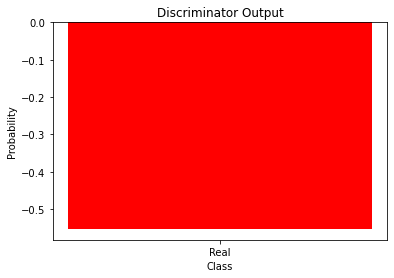

In [25]:
# Get the probability score
probability_score = discriminator_output.item()

# Plot the discriminator output
plt.bar(['Real'], [probability_score], color=['blue' if probability_score > 0.5 else 'red'])
plt.xlabel('Class')
plt.ylabel('Probability')
plt.title('Discriminator Output')
plt.show()

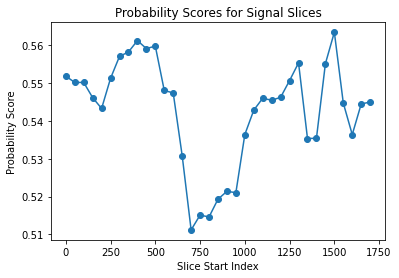

Average Probability: 0.5428726741245815


In [26]:

# Function to calculate probability score for a given signal slice
def calculate_probability_score(model, signal_slice):
    # Pad the signal to match the expected size (1824)
    padded_signal = np.pad(signal_slice.values, (0, 1824 - len(signal_slice)), mode='constant')

    signal_tensor = torch.tensor(padded_signal, dtype=torch.float32)
    signal_tensor = signal_tensor.unsqueeze(0).unsqueeze(1)

    # Set the discriminator to evaluation mode
    model.eval()

    # Perform the forward pass (without sigmoid)
    with torch.no_grad():
        discriminator_output = model(signal_tensor)

        # Get the probability score
        #probability_score = discriminator_output.item()
        probability_score = torch.sigmoid(discriminator_output).item()
    return probability_score

# Read the signal data from the Excel file
file_path = r'C:\filtered_signal13.xlsx'
df = pd.read_excel(file_path, header=None)
df = pd.to_numeric(df[0], errors='coerce')

# Define the slice parameters
slice_length = 100
stride = 50

# Lists to store results
slice_start_indices = []
probability_scores = []

# Iterate over slices and calculate probability scores
for start_idx in range(0, len(df) - slice_length + 1, stride):
    slice_start_indices.append(start_idx)
    signal_slice = df[start_idx : start_idx + slice_length]
    score = calculate_probability_score(loaded_discriminator, signal_slice)
    probability_scores.append(score)

# Plot the results
plt.plot(slice_start_indices, probability_scores, marker='o')
plt.title('Probability Scores for Signal Slices')
plt.xlabel('Slice Start Index')
plt.ylabel('Probability Score')
plt.show()

def calculate_average(probability_scores):
    if not probability_scores:
        return 0  # Return 0 if the list is empty to avoid division by zero error

    total = sum(probability_scores)
    average = total / len(probability_scores)
    return average
average = calculate_average(probability_scores)
print("Average Probability:", average)


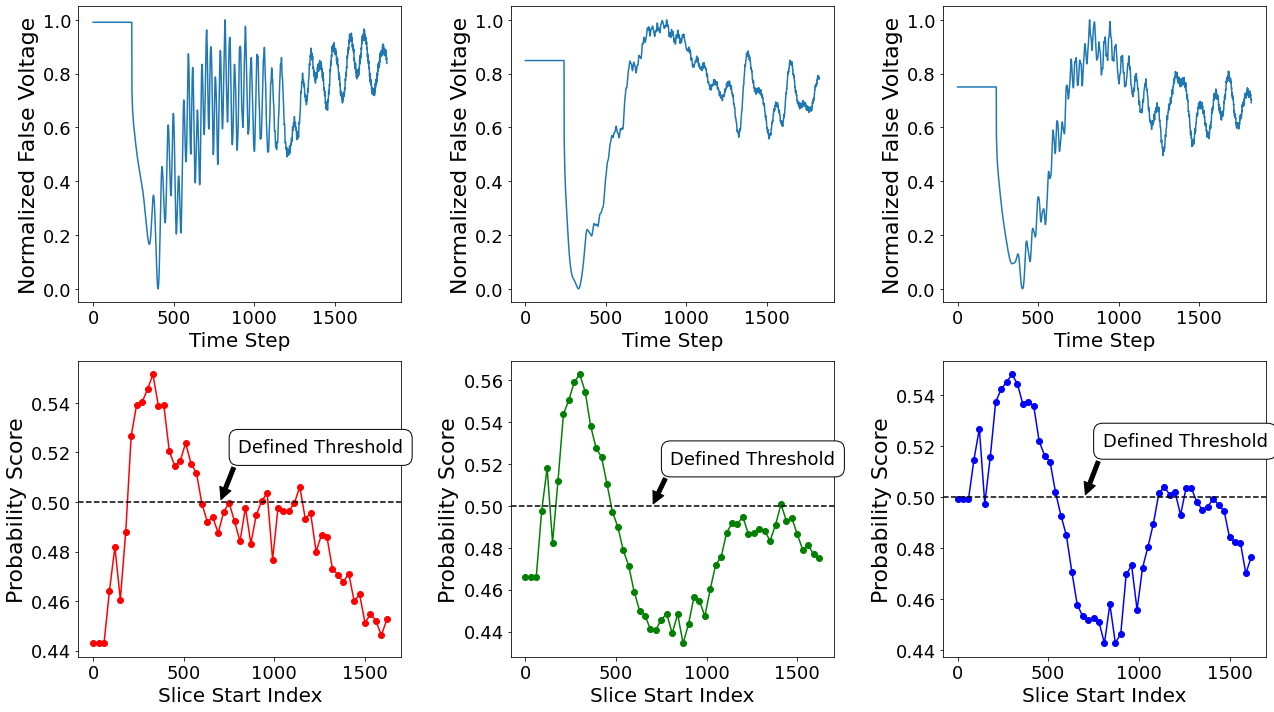

In [106]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

def calculate_probability_score(model, signal_slice):
    # Pad the signal to match the expected size (1824)
    padded_signal = np.pad(signal_slice.values, (0, 1824 - len(signal_slice)), mode='constant')

    signal_tensor = torch.tensor(padded_signal, dtype=torch.float32)
    signal_tensor = signal_tensor.unsqueeze(0).unsqueeze(1)

    # Set the discriminator to evaluation mode
    model.eval()

    # Perform the forward pass (without sigmoid)
    with torch.no_grad():
        discriminator_output = model(signal_tensor)
        probability_score = torch.sigmoid(discriminator_output).item()

    # Get the probability score
    #probability_score = discriminator_output.item()
    return probability_score

# List of file paths
file_paths = [r'C:\filtered_signal10.xlsx',
              r'C:\filtered_signal12.xlsx',
              r'C:\filtered_signal14.xlsx']

# Create a 2-row, 3-column subplot arrangement
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

# Colors for the probability scores plots
probability_score_colors = ['red', 'green', 'blue']

# Iterate over each file path
for i, file_path in enumerate(file_paths):
    # Read the signal data from the Excel file
    df = pd.read_excel(file_path, header=None)
    df = pd.to_numeric(df[0], errors='coerce')

    # Define the slice parameters
    slice_length = 180
    stride = 30

    # Lists to store results
    slice_start_indices = []
    probability_scores = []

    # Iterate over slices and calculate probability scores
    for start_idx in range(0, len(df) - slice_length + 1, stride):
        slice_start_indices.append(start_idx)
        signal_slice = df[start_idx: start_idx + slice_length]
        score = calculate_probability_score(loaded_discriminator, signal_slice)
        probability_scores.append(score)

    # Plot the signal in the subplot at 1x(i+1)
    axs[0, i].plot(df, label='False Data')

    # Plot the probability scores in the subplot at 2x(i+1) with the specified color
    axs[1, i].plot(slice_start_indices, probability_scores, marker='o', color=probability_score_colors[i],
                   label='Probability Score')
    
    # Draw a dashed line at y=0.5
    axs[1, i].axhline(0.5, color='black', linestyle='--', linewidth=1.5) #label='Zero Line')
    # Annotate local max with increased font size and in a box
    
    axs[1, i].annotate('Defined Threshold', xy=(700, 0.5), xytext=(800, 0.520),
                   fontsize=18, bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='black'),
                   arrowprops=dict(facecolor='black', shrink=0.05))
    

    axs[1, i].set_xlabel('Slice Start Index', fontsize=20)
    axs[0, i].set_xlabel('Time Step', fontsize=20)
    axs[1, i].set_ylabel('Probability Score', fontsize=22)
    axs[0, i].set_ylabel('Normalized False Voltage', fontsize=22)
    axs[1, i].tick_params(axis='both', which='both', labelsize=18)
    axs[0, i].tick_params(axis='both', which='both', labelsize=18)

# Adjust layout
plt.tight_layout()

# Save the plots as a PDF
plt.savefig('Probability_Score.pdf')


# Show the plots
plt.show()